In [1]:
import pandas as pd
from mplsoccer.pitch import Pitch
from matplotlib.colors import to_rgba
import numpy as np
from mplsoccer.statsbomb import read_event, EVENT_SLUG

In [2]:
match_id = 15946 # (Deportivo (H), 2018/19 La Liga)
team = 'Barcelona'
opponent = 'Deportivo (H), 2018/19 La Liga'
event_dict = read_event(f'{EVENT_SLUG}/{match_id}.json', warn=False)
players = event_dict['tactics_lineup']
events = event_dict['event']

In [3]:
# adding on the last tactics id and formation for the team for each event
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[['tactics_id', 'tactics_formation']].ffill()

In [4]:
# add the abbreviated player position to the players dataframe
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB', 8: 'LWB', 9: 'RDM',
                  10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM', 14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW',
                  18: 'RAM', 19: 'CAM', 20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.player_position_id.map(formation_dict)

In [5]:
# add on the subsitutions to the players dataframe, i.e. where players are subbed on but the formation doesn't change
sub = events.loc[events.type_name == 'Substitution', ['tactics_id', 'player_id', 'substitution_replacement_id',
                                                      'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'), on=['id', 'player_id'],
                            how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [6]:
# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'}, axis='columns'),
                      on=['tactics_id', 'pass_recipient_id'], how='left', validate='m:1', suffixes=['', '_receipt'])

In [7]:
# get a dataframe with all passes
mask_pass = (events.team_name == team) & (events.type_name == 'Pass')
to_keep = ['id', 'match_id', 'player_id', 'player_name', 'outcome_name', 'pass_recipient_id', 'pass_recipient_name',
           'x', 'y', 'end_x', 'end_y', 'tactics_id', 'tactics_formation', 
           'position_abbreviation', 'position_abbreviation_receipt']
passes = events.loc[mask_pass, to_keep].copy()
# get a dataframe with the player locations for any events with an x coordinate
player_locs =  events.loc[(events.team_name == team) & (events['x'].notnull()), 
                          ['id','match_id', 'player_id', 'player_name', 'x', 'y',
                           'tactics_id', 'tactics_formation', 'position_abbreviation']]

# Passing network for a set formation

In [8]:
formation = 433
passes_formation = passes[(passes.tactics_formation == formation) & (passes.position_abbreviation_receipt.notnull())].copy()
player_locs_formation = player_locs[player_locs.tactics_formation == formation].copy()
average_locs_and_count = player_locs_formation.groupby('position_abbreviation').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

In [9]:
# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = passes_formation[['position_abbreviation', 'position_abbreviation_receipt']].max(axis='columns')
passes_formation['pos_min'] = passes_formation[['position_abbreviation', 'position_abbreviation_receipt']].min(axis='columns')
passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
# add on the location of each player so we have the start and end positions of the lines
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True, suffixes=['', '_end'])

In [10]:
# calculate the line width and marker sizes relative to the largest counts
max_line_width = 18
max_marker_size = 3000
passes_between['width'] = passes_between.pass_count / passes_between.pass_count.max() * max_line_width
average_locs_and_count['marker_size'] = (average_locs_and_count['count'] / average_locs_and_count['count'].max() * 
                                         max_marker_size)

In [11]:
min_transparency = 0.3
# set line transparency relative to a minimum transparency
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

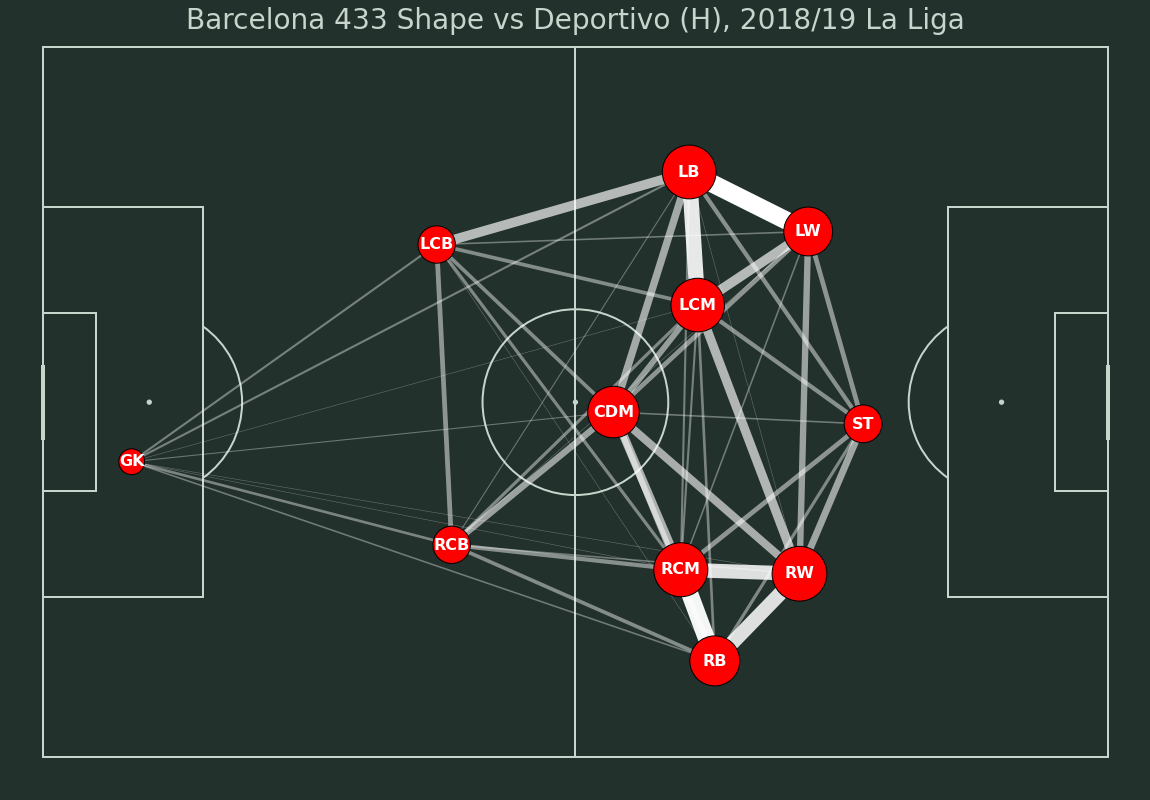

In [12]:
pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(16,11),
              constrained_layout=True, tight_layout=False)
fig, ax = pitch.draw()
pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=ax)
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y, s=average_locs_and_count.marker_size,
                           color='red', edgecolors='black', linewidth=1, alpha=1,  ax=ax)
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center', ha='center', size=16, weight='bold', ax=ax)
title = ax.set_title("{} {} Shape vs {}".format(team, formation, opponent), size=28, y=0.97, color='#c7d5cc')
fig.set_facecolor("#22312b")